In [281]:
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import pylab as pl
import random

In [546]:
TAM_IMAGE = 8
SCALING_LINES = 0.4
THRESHOLD = 0.1
DIFUSION_PARAMETER = 1
MINIMUM_CLUSTERS_SIZE = 2
d_0 = 5
theta_0 = np.pi / 8
delta = 1 / 3


In [547]:
def distance_perona(point_i, point_j):
    d_1 = -((point_j[0] - point_i[0])**2 + (point_j[1] - point_i[1])**2)/(d_0**2)
    d_2 = -(2 - np.cos(2 * point_i[2]) - np.cos(2 * point_j[2]))/(1 - np.cos(2 * theta_0))
    d_3 = -(1 - np.cos(2 * point_i[2] - 2 * point_j[2]))/(1 - np.cos(2 * delta * theta_0 ))
    return np.exp(d_1 + d_2 + d_3)

In [548]:
# Ejemplo diagonal:
point_i = [0, 0, np.pi / 4]
point_j = [1, 1, np.pi / 4]
distance_perona(point_i, point_j)

0.0009993283798737766

In [549]:
def random_points(prob_elim):
    points = []
    for x in range(TAM_IMAGE):
        for y in range(TAM_IMAGE):
            if(np.random.random() < prob_elim):
                continue
            else:
                points.append([x, y, np.random.random() * 2 * np.pi])
    return points

In [550]:
def affinity_matrix(points):
    A = []
    for point_i in points:
        array = []
        for point_j in points:
            array.append(distance_perona(point_i, point_j))
        A.append(array.copy())
    return np.asmatrix(A)

In [551]:
def degree_matrix(affinity_matrix):
    length = len(affinity_matrix)
    D = np.zeros((length, length))
    for x in range(length):
        sum = 0
        for y in range(length):
            sum += affinity_matrix[x,y]
        D[x][x] = sum
    return np.asmatrix(D)

In [552]:
def random_points_with_diagonal(prob_elim):
    points = random_points(prob_elim)
    points = [point for point in points if point[0] != point[1]]
    for i in range(TAM_IMAGE):
        points.append([i, i, np.pi / 4])
    return points

In [553]:
def spectral_clustering(points):
    # Paso 1
    A = affinity_matrix(points)
    
    # Paso 2
    D = degree_matrix(A)
    Lrw = np.matmul(np.linalg.inv(D), A)

    # Paso 3
    vals, vects = np.linalg.eig(Lrw)
    vects = vects.transpose()
    eig = [vals, vects]

    #Ordenamos los autovectores de manera decreciente:
    indices = list(range(len(eig[0])))
    indices.sort(key = eig[0].__getitem__, reverse=True)
    for i, sublist in enumerate(eig):
        eig[i] = [sublist[j] for j in indices]
        
    # Paso 5
    print(eig[0])
    q = len(eig[0]) - 1
    for i in range(len(eig[0])):
        if(eig[0][i] < 1 - THRESHOLD):
            q = i - 1
            break

    # Paso 6
    clusters = []
    for i in range(q):
        clusters.append([])

    for i in range(len(points)):
        index_max = 0
        max = eig[1][0][0,i]
        for j in range(1,q):
            if(eig[1][j][0,i] > max):
                index_max = j
                max = eig[1][j][0,i]
        clusters[index_max].append(indices[i])
        
    # Paso 7
    alone_cluster = []
    for cluster in clusters:
        if(len(cluster) < MINIMUM_CLUSTERS_SIZE):
            alone_cluster += cluster
    clusters = [cluster for cluster in clusters if len(cluster) >= MINIMUM_CLUSTERS_SIZE]
    clusters = [alone_cluster] + clusters
    return clusters, indices

In [554]:
points = random_points_with_diagonal(0.8)
clusters, indices = spectral_clustering(points)

[1.0000000000000013, 0.9999999030139806, 0.9999657360154292, 0.9892141472428091, 0.9670292294367159, 0.961642812141421, 0.9322478796059777, 0.5129714879014637, 0.41402582686390405, 0.24589823752815693, 0.17409806728722665, 0.1452779381405325, 0.10895990829893311, 0.04365581284703128, 0.028904901106703955, 0.003836023571638138, 0.00034374356817222214, 1.9208077963301803e-05, 5.164198512321038e-07]


In [555]:
print(clusters)

[[9], [6, 3, 0], [5, 1, 7, 10], [4, 12, 13, 11, 14, 15, 16, 17, 18], [2, 8]]


In [556]:
def print_image(points, clusters):
    lines = []
    for point in points:
        x = point[0]
        y = point[1]
        theta = point[2]
        cos = np.cos(theta)
        sen = np.sin(theta)
        lines.append([(x + SCALING_LINES * cos, y + SCALING_LINES * sen), 
                        (x - SCALING_LINES * cos, y - SCALING_LINES * sen)])
            
    colors_search = [[0,0,0,100]]
    for _ in range(len(clusters) - 1):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        w = random.randint(0,255)
        colors_search.append([r, g, b, w])        
    
    colors = []
    for i in range(len(points)):
        ind = [i in cluster for cluster in clusters].index(True)
        colors.append(colors_search[ind])

    # We need to set the plot limits.
    fig, ax = plt.subplots()
    ax.set_xlim(0, TAM_IMAGE)
    ax.set_ylim(0, TAM_IMAGE)
    
    line_segments = LineCollection(lines, linewidths=(0.5, 1, 1.5, 2),
                               colors=colors, linestyle='solid')
    ax.add_collection(line_segments)
    ax.set_title('Line collection with masked arrays')
    plt.show()


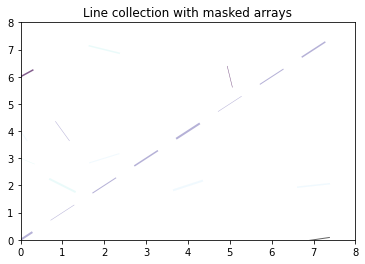

In [557]:
print_image(points, clusters)